# Porównanie Skuteczności Metod Klasyfikacji: Drzewa Decyzyjne vs. Naiwny Klasyfikator Bayesowski
***Zuzanna Piekarczyk, nr albumu: 141771***

## Opis:

Niniejszy projekt skupia się na analizie oraz porównaniu efektywności dwóch popularnych metod klasyfikacji: 
- klasyfikacyjnych drzew decyzyjnych,
- naiwnego klasyfikatora bayesowskiego. 

Klasyfikacyjne drzewa decyzyjne oraz naiwny klasyfikator bayesowski są powszechnie stosowane w dziedzinie uczenia maszynowego i analizy danych, ze względu na ich prostotę oraz zdolność do generowania zrozumiałych reguł klasyfikacyjnych.

W ramach tego projektu, przeprowadzone zostaną szczegółowe analizy działania obu metod, włączając w to ich teoretyczne podstawy oraz praktyczne zastosowanie. Dokładnie zostaną omówione etapy procesu klasyfikacji, począwszy od przetwarzania danych, przez trenowanie modeli, aż do oceny ich skuteczności.

### Główne cele projektu:

1. Przedstawienie różnic pomiędzy klasyfikacyjnymi drzewami decyzyjnymi a naiwnym klasyfikatorem bayesowskim pod względem założeń oraz sposobu konstrukcji modeli.
3. Implementacja obu metod klasyfikacji w środowisku programistycznym, włączając w to biblioteki do uczenia maszynowego.
4. Przeprowadzenie klasyfikacji danych przy użyciu obu metod na zestawie danych testowych.
5. Ocena skuteczności każdej z metod na podstawie miar takich jak dokładność klasyfikacji, czułość, specyficzność itp.
6. Porównanie wyników oraz wyciągnięcie wniosków dotyczących skuteczności i zastosowań obu metod klasyfikacji.

## Dane:

Zbiór wykorzystany w projekcie pochodzi z [artukułu naukowego](https://dergipark.org.tr/tr/download/article-file/1227592) opublikowanego przez trzech badaczy Selcuk University i dotyczy dwóch odmian rodzynek uprawianych w Turcji: Besni oraz Kecimen. 

Dane do analizy zostały zgromadzone poprzez zebranie próbek ziaren rodzynków – łącznie 900 próbek, przy równomiernym uwzględnieniu obu odmian. Następnie obrazy tych próbek zostały utrwalone za pomocą aparatu fotograficznego lub kamery, tworząc cyfrowe obrazy, gotowe do analizy przy użyciu systemu wizji maszynowej. Proces pozyskiwania danych mógł obejmować zarówno manualne, jak i automatyczne sortowanie oraz etykietowanie próbek, zapewniając każdej z nich odpowiednie przypisanie do konkretnej odmiany.

Zbiór składa się z następujących zmiennych:

1. **Obszar (Area):** 
Określa liczbę pikseli znajdujących się w granicach ziarna rodzynka.

2. **Obwód (Perimeter):** 
Mierzy otoczenie poprzez obliczenie odległości między granicami ziarna rodzynka a pikselami wokół niego.

3. **Długość Głównego Wymiaru (MajorAxisLength):** 
Określa długość głównej osi, czyli najdłuższej linii, którą można narysować na ziarnie rodzynka.

4. **Długość Mniejszego Wymiaru (MinorAxisLength):** 
Określa długość małej osi, czyli najkrótszej linii, którą można narysować na ziarnie rodzynka.

5. **Ekscentryczność (Eccentricity):** 
Miara ekscentryczności elipsy, która ma takie same momenty jak rodzynki.

6. **Obszar Wypukły (ConvexArea):** 
Określa liczbę pikseli najmniejszej powłoki wypukłej regionu utworzonego przez ziarno rodzynka.

7. **Współczynnik Rozległości (Extent):** 
Stosunek regionu utworzonego przez ziarno rodzynka do całkowitej liczby pikseli w otaczającej ramce.



### Wczytanie bibliotek

In [1]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import * 
from pyspark.ml.feature import StringIndexer 
from pyspark.ml.classification import NaiveBayes

### Inicjalizacja sesji Spark

In [2]:
spark = SparkSession.builder.appName("example").getOrCreate()

24/02/05 16:55:26 WARN Utils: Your hostname, Zuzas-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.0.101 instead (on interface en0)
24/02/05 16:55:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/05 16:55:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Załadowanie danych

In [3]:
raisin = spark.read.format("csv").option("header", "true").load("/Users/zuzapiekarczyk/Documents/big data/Raisin_Dataset.csv")

### Eksploracja danych

#### Wyświetlenie 5-ciu pierwszych rekordów

In [4]:
#raisin.show(5)

#### Zmiana nazwy i typu danych w kolumnie klasyfikującej
W celu przygotowania zbioru pod klasyfikację, dokonano zmiany nazwy kolumny "Class" na "Target" oraz zmiany wartości zgodnie ze schematem:

0 - Rodzynka gatunku Besni (a)

1 - Rodzynka gatunku Kecimen (b)

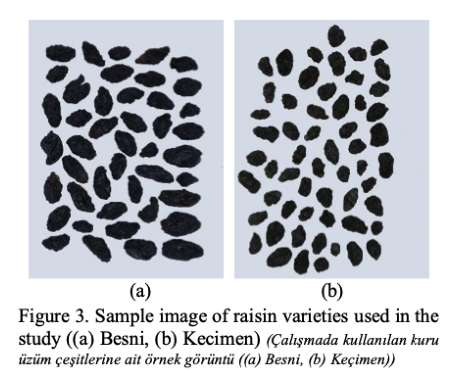

In [5]:
image_path = "/Users/zuzapiekarczyk/Documents/big data/raisins.png"
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

In [6]:
raisin = raisin.withColumnRenamed("Class", "Target")
raisin = raisin.withColumn("Target", when(raisin["Target"] == "Besni", 0).otherwise(1))
#raisin.show(5)

#### Liczebności rodzynek w podziale na gatunki

In [7]:
distinct_values_count = raisin.select('Target').distinct().count()
occurrences_count = raisin.groupBy('target').count()
print("Liczba różnych wartości w kolumnie 'Target':", distinct_values_count)
print("\nIlość wystąpień każdej wartości:")
occurrences_count.show()

Liczba różnych wartości w kolumnie 'Target': 2

Ilość wystąpień każdej wartości:
+------+-----+
|target|count|
+------+-----+
|     1|  450|
|     0|  450|
+------+-----+



Zgodnie z załozeniami w kolumnie "Target" występują dwa gatunki rodzynek, a liczebności obu z nich są równe i wynoszą po 450 wierszy.

### Wyświetlenie schematu zbioru

In [8]:
#raisin.printSchema()

#### Wyświetlenie podstawowych statystyk opisowych

In [9]:
#raisin.describe().show()

#### Zmiana typu danych i zaokrąglenie zmiennych do dwóch miejsc po przecinku

In [10]:
raisin_double = raisin.select(
    col("Area").cast("double"),
    col("MajorAxisLength").cast("double"),
    col("MinorAxisLength").cast("double"),
    col("Eccentricity").cast("double"),
    col("ConvexArea").cast("double"),
    col("Extent").cast("double"),
    col("Perimeter").cast("double"),
    "Target"
)
raisin = raisin_double.select(
    round("Area", 2).alias("Area"),
    round("MajorAxisLength", 2).alias("MajorAxisLength"),
    round("MinorAxisLength", 2).alias("MinorAxisLength"),
    round("Eccentricity", 2).alias("Eccentricity"),
    round("ConvexArea", 2).alias("ConvexArea"),
    round("Extent", 2).alias("Extent"),
    round("Perimeter", 2).alias("Perimeter"),
    "Target"
)

#### Sprawdzenie, czy istnieją braki danych

In [11]:
missing_values = raisin.select([col(c).isNull().cast("int").alias(c) for c in raisin.columns])\
                       .agg(*[sum(col(c)).alias(c) for c in raisin.columns])\
                       .toPandas()
print("Liczba braków danych w poszczególnych kolumnach:")
print(missing_values)

Liczba braków danych w poszczególnych kolumnach:
   Area  MajorAxisLength  MinorAxisLength  Eccentricity  ConvexArea  Extent  \
0     0                0                0             0           0       0   

   Perimeter  Target  
0          0       0  


Dane nie posiadają brakujących wartości.

#### Histogramy zmiennych

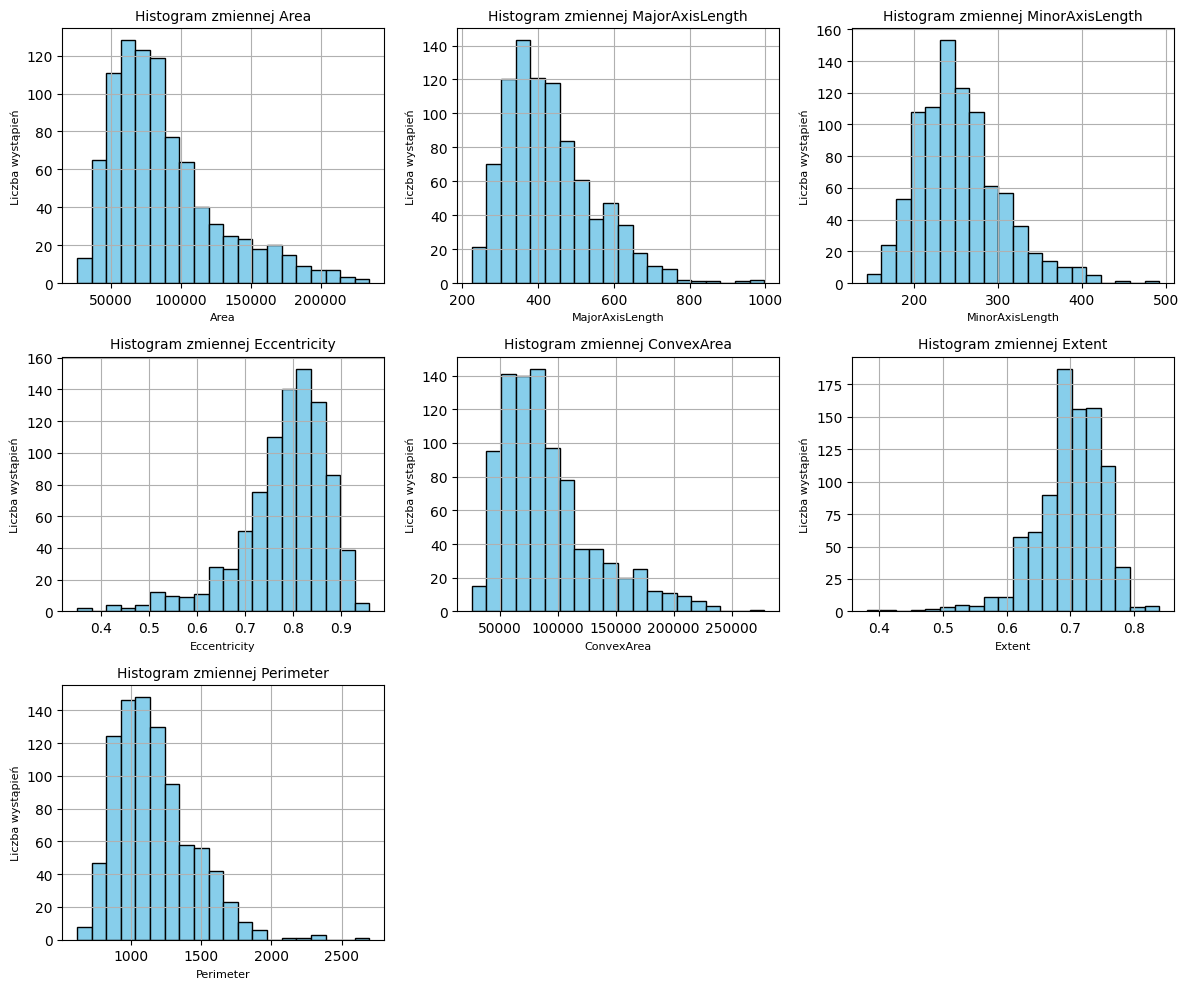

In [12]:
plt.figure(figsize=(12, 10))
for i, column in enumerate(raisin.columns):
    if column != "Target":
        plt.subplot(3, 3, i+1) 
        plt.hist(raisin.select(column).rdd.flatMap(lambda x: x).collect(), bins=20, color='skyblue', edgecolor='black')
        plt.title(f'Histogram zmiennej {column}', fontsize=10)  
        plt.xlabel(column, fontsize=8)
        plt.ylabel('Liczba wystąpień', fontsize=8) 
        plt.grid(True)
plt.tight_layout()
plt.show()

#### Boxploty zmiennych

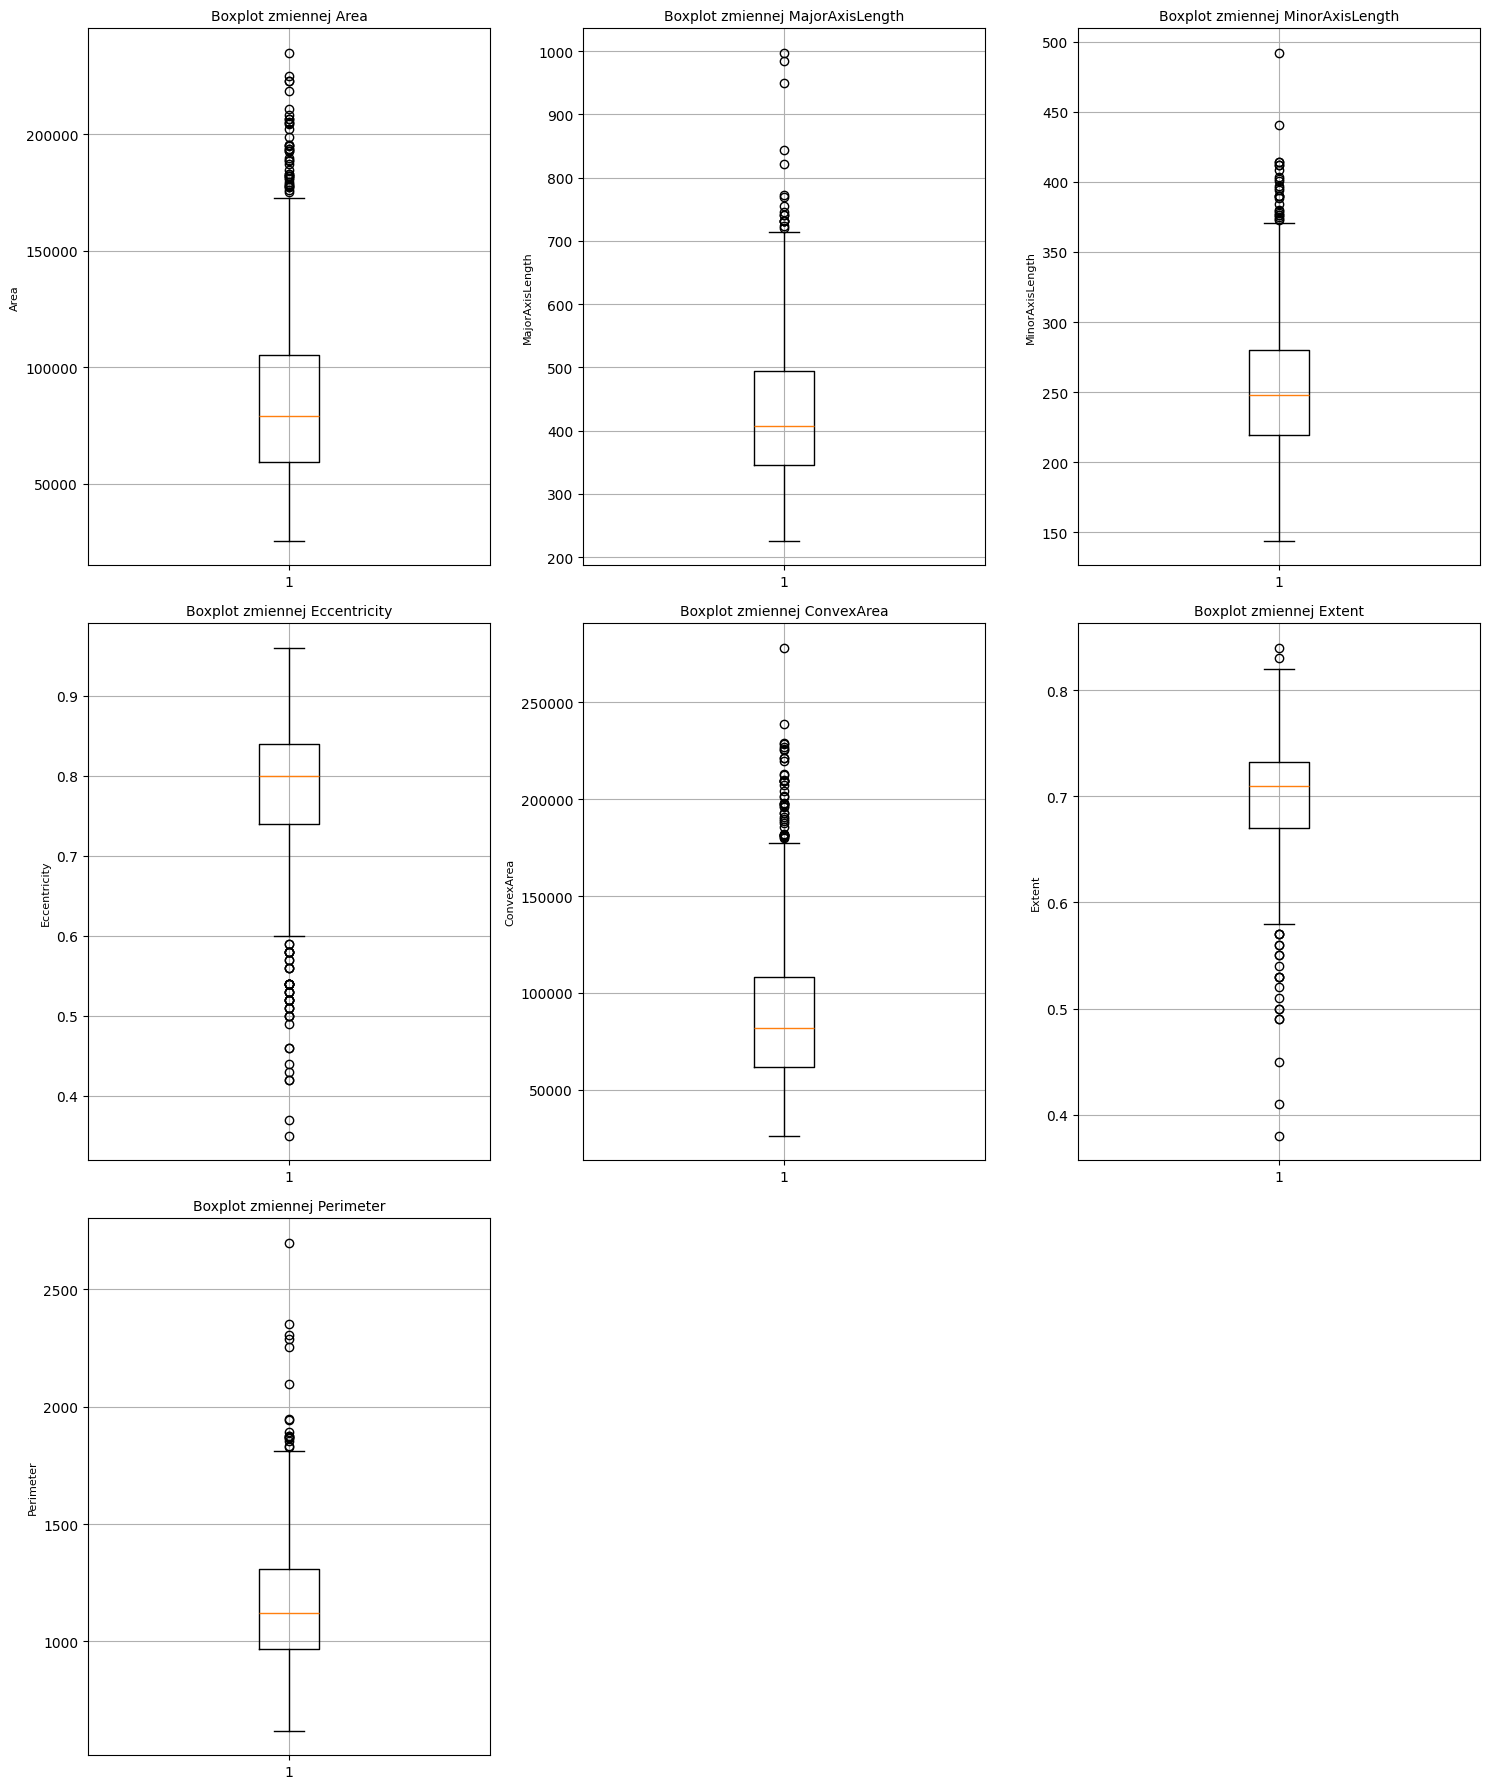

In [13]:
plt.figure(figsize=(15, 18))
variables = ['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'ConvexArea', 'Extent', 'Perimeter']
for i, variable in enumerate(variables):
    plt.subplot(3, 3, i+1)  
    plt.boxplot(raisin.select(variable).rdd.flatMap(lambda x: x).collect())  
    plt.title(f'Boxplot zmiennej {variable}', fontsize=10)  
    plt.ylabel(variable, fontsize=8) 
    plt.grid(True)
plt.tight_layout()
plt.show()

#### Wykres zalezności między długością a szerokością rodzynek

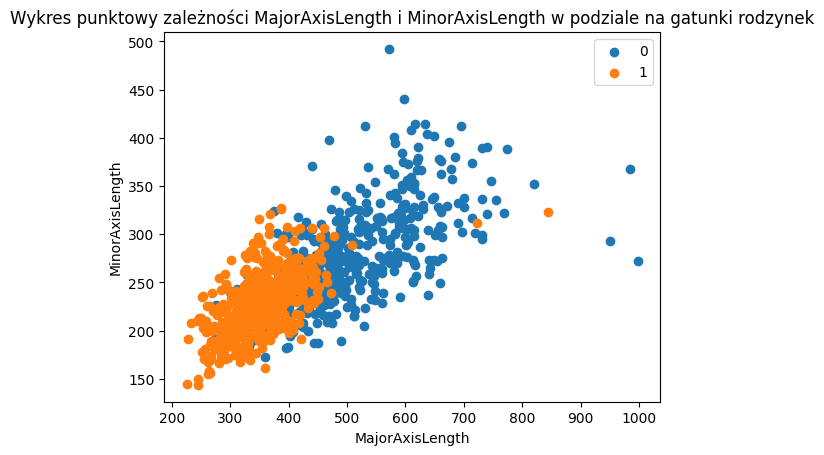

In [14]:
data = raisin.select('MajorAxisLength', 'MinorAxisLength', 'Target').toPandas()
grouped_data = data.groupby('Target')
for group, df in grouped_data:
    plt.scatter(df['MajorAxisLength'], df['MinorAxisLength'], label=group)
plt.xlabel('MajorAxisLength')
plt.ylabel('MinorAxisLength')
plt.title('Wykres punktowy zależności MajorAxisLength i MinorAxisLength w podziale na gatunki rodzynek')
plt.legend()
plt.show()

#### Wykres zalezności między obszarem a obwodem rodzynek

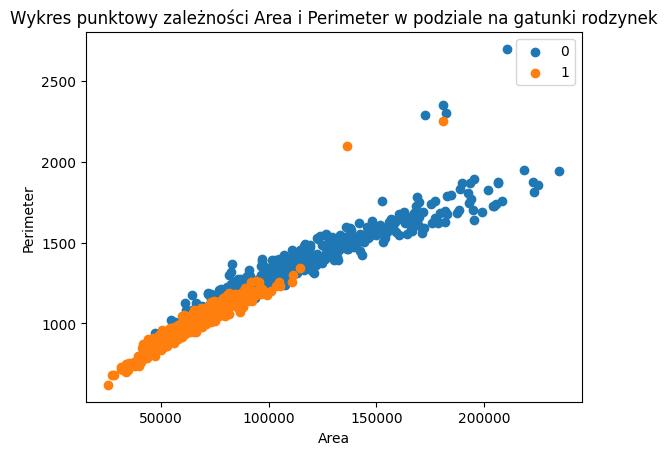

In [15]:
data = raisin.select('Area', 'Perimeter', 'Target').toPandas()
grouped_data = data.groupby('Target')
for group, df in grouped_data:
    plt.scatter(df['Area'], df['Perimeter'], label=group)
plt.xlabel('Area')
plt.ylabel('Perimeter')
plt.title('Wykres punktowy zależności Area i Perimeter w podziale na gatunki rodzynek')
plt.legend()
plt.show()

## Drzewa decyzyjne klasyfikacyjne

#### Wybranie cech i etykiet

In [16]:
vector_assembler = VectorAssembler(
    inputCols=["Area", "MajorAxisLength", "MinorAxisLength", "Eccentricity", "ConvexArea", "Extent", "Perimeter"],
    outputCol="features"
)
raisin = vector_assembler.transform(raisin)

#### Podział zbioru na podzbiór treningowy i testowy w proporcji 80/20

In [17]:
train_data, test_data = raisin.randomSplit([0.8, 0.2], seed=123)

#### Budowa klasyfikatora drzewa decyzyjnego

In [18]:
tree_classifier = DecisionTreeClassifier(featuresCol="features", labelCol="Target", maxDepth=10, seed=101, minInstancesPerNode=10)

#### Wytrenowanie modelu

In [19]:
tree_model = tree_classifier.fit(train_data)

#### Wypróbowanie modelu na zbiorze testowym

In [20]:
tree_model_predictions = tree_model.transform(test_data)

#### Ocena modelu

In [21]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="Target", metricName="accuracy")
accuracy = evaluator.evaluate(tree_model_predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8290155440414507


In [22]:
correct_predictions = tree_model_predictions.filter(col("Target") == col("prediction")).count()
total_predictions = tree_model_predictions.count()
precision = correct_predictions / total_predictions
print("Precision:", precision)

CodeCache: size=131072Kb used=38493Kb max_used=38503Kb free=92578Kb
 bounds [0x00000001091e0000, 0x000000010b7b0000, 0x00000001111e0000]
 total_blobs=14185 nmethods=13139 adapters=955
 compilation: disabled (not enough contiguous free space left)
Precision: 0.8290155440414507


Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


In [23]:
prediction_and_label = tree_model_predictions.select("prediction", "Target").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(prediction_and_label)
confusion_matrix = metrics.confusionMatrix()
print("Confusion Matrix:")
print(confusion_matrix)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix:
DenseMatrix([[84., 16.],
             [17., 76.]])


Precision (precyzja) o wartości około 0.83 oznacza, że dla danego modelu klasyfikacyjnego, który został użyty do klasyfikacji wieloklasowej, około 83% przypadków sklasyfikowanych jako pozytywne są poprawnie sklasyfikowane.

#### Macierz pomyłek:
- Rodzynki Besni (klasa 0):
    - 84 przypadki zostały poprawnie sklasyfikowane jako rodzynki Besni.
    - 17 przypadków rodzynek Besni zostały błędnie sklasyfikowane jako rodzynki Kecimen.
- Rodzynki Kecimen (klasa 1):
    - 76 przypadków rodzynek Kecimen zostały poprawnie sklasyfikowane jako rodzynki Kecimen.
    - 16 przypadków rodzynek Kecimen zostały błędnie sklasyfikowane jako rodzynki Besni.

In [24]:
dt_classifier = DecisionTreeClassifier(featuresCol="features", labelCol="Target")
pipeline = Pipeline(stages=[dt_classifier])

param_grid = ParamGridBuilder().addGrid(dt_classifier.maxDepth, [2, 3, 4, 5, 7, 10, 12, 20]) \
                                .addGrid(dt_classifier.minInstancesPerNode, [2, 3, 4, 5, 6, 8, 10, 20]) \
                                .build()

cross_validator = CrossValidator(estimator=pipeline,
                                 estimatorParamMaps=param_grid,
                                 evaluator=MulticlassClassificationEvaluator(labelCol="Target", predictionCol="prediction", metricName="accuracy"),
                                 numFolds=5)

cv_model = cross_validator.fit(train_data)
predictions = cv_model.transform(test_data)

accuracy = MulticlassClassificationEvaluator(labelCol="Target", predictionCol="prediction", metricName="accuracy").evaluate(predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8808290155440415


In [25]:
correct_predictions = predictions.filter(col("Target") == col("prediction")).count()
total_predictions = predictions.count()
precision = correct_predictions / total_predictions
print("Precision:", precision)

Precision: 0.8808290155440415


In [26]:
prediction_and_label = predictions.select("prediction", "Target").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(prediction_and_label)
confusion_matrix = metrics.confusionMatrix()
print("Confusion Matrix:")
print(confusion_matrix)

Confusion Matrix:
DenseMatrix([[89., 11.],
             [12., 81.]])


In [27]:
best_model = cv_model.bestModel
best_max_depth = best_model.stages[0].getOrDefault("maxDepth")
best_min_instances_per_node = best_model.stages[0].getOrDefault("minInstancesPerNode")
print(f"Best Max Depth: {best_max_depth}")
print(f"Best Min Instances Per Node: {best_min_instances_per_node}")

Best Max Depth: 3
Best Min Instances Per Node: 20


Optymalne drzewo regresji zostało osiągnięte przy użyciu parametrów 'max_depth' równego 3 i 'min_samples_leaf' równego 20.Precision dla ostatecznego modelu wynosi 88%, co oznacza, że dla klasyfikacji wieloklasowej model poprawnie sklasyfikował 88% przypadków.

##### Macierz pomyłek:
- Rodzynki Besni (klasa 0): poprawnie sklasyfikowane 89 przypadków.
- Rodzynki Kecimen (klasa 1): poprawnie sklasyfikowane 81 przypadków.

#### Wizualizacja predykcji

In [28]:
best_model = cv_model.bestModel
final_tree_classifier = best_model.stages[0]
tree_structure = final_tree_classifier._java_obj.toDebugString()
print("Decision Tree Structure:")
print(tree_structure)

Decision Tree Structure:
DecisionTreeClassificationModel: uid=DecisionTreeClassifier_3206bf367b06, depth=2, numNodes=5, numClasses=2, numFeatures=7
  If (feature 1 <= 417.02)
   If (feature 4 <= 88342.5)
    Predict: 1.0
   Else (feature 4 > 88342.5)
    Predict: 0.0
  Else (feature 1 > 417.02)
   Predict: 0.0



## Naiwny Klasyfikator Bayesowski

#### Ustawienie etykiety

In [41]:
label_column = "Target"

#### Stworzenie naiwnego klasyfikatora Bayesa oraz pipeline

In [42]:
naive_bayes = NaiveBayes(modelType="multinomial", featuresCol="features", labelCol=label_column)
pipeline = Pipeline(stages=[vector_assembler, naive_bayes])

#### Podział zbioru na podzbiór treningowy i testowy w proporcji 80/20

In [43]:
raisin_nai = raisin.withColumnRenamed("features", "input_features")
train_data, test_data = raisin_nai.randomSplit([0.8, 0.2], seed=42)

#### Wytrenowanie modelu

In [44]:
model = pipeline.fit(train_data)

#### Wypróbowanie modelu na zbiorze testowym

In [45]:
predictions = model.transform(test_data)

#### Ocena modelu

In [46]:
evaluator = MulticlassClassificationEvaluator(labelCol=label_column, predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
print(f"Precision: {precision}")
confusion_matrix = predictions.groupBy(label_column, "prediction").count()
confusion_matrix.show()

Accuracy: 0.7534246575342466
Precision: 0.7710491146007351
+------+----------+-----+
|Target|prediction|count|
+------+----------+-----+
|     1|       0.0|   10|
|     0|       0.0|   54|
|     1|       1.0|   56|
|     0|       1.0|   26|
+------+----------+-----+



Precision (precyzja) o wartości około 0.77 oznacza, że dla danego modelu klasyfikacyjnego, około 77% przypadków sklasyfikowanych jako pozytywne są poprawnie sklasyfikowane.

#### Macierz pomyłek:
- Dla rodzynków Besni (klasa 0):
    - Poprawnie sklasyfikowane jako rodzynki Besni: 54 przypadki.
    - Błędnie sklasyfikowane jako rodzynki Kecimen: 26 przypadków.
- Dla rodzynków Kecimen (klasa 1):
    - Poprawnie sklasyfikowane jako rodzynki Kecimen: 56 przypadków.
    - Błędnie sklasyfikowane jako rodzynki Besni: 10 przypadków.

## Podsumowanie i wnioski

Podczas projektu przeprowadzono klasyfikację dwóch gatunków rodzynków wykorzystując dwa różne modele: klasyfikacyjne drzewo decyzyjne oraz naiwny klasyfikator Bayesa. 

Drzewa klasyfikacyjne to modele uczenia maszynowego, które działają na zasadzie podziału danych na podgrupy, opierając się na zestawie reguł decyzyjnych. Każdy wierzchołek drzewa reprezentuje test na wartości pewnej cechy, który prowadzi do podziału danych na dwie lub więcej gałęzi. W końcowym efekcie, drzewo klasyfikacyjne przewiduje przynależność do konkretnej klasy na podstawie serii testów przeprowadzanych na cechach obserwacji.

Z kolei naiwny klasyfikator Bayesa opiera się na zastosowaniu twierdzenia Bayesa w kontekście klasyfikacji. Zakłada on naiwnie, że wszystkie cechy są niezależne od siebie, co oznacza, że prawdopodobieństwo przynależności do danej klasy jest wyznaczane na podstawie prawdopodobieństw cech. Choć jest to założenie uproszczone i nierzeczywiste w większości przypadków, naiwny klasyfikator Bayesa jest nadal skutecznym narzędziem, szczególnie w przypadku dużych zbiorów danych.

Analiza wyników wykazała, że model oparty na klasyfikacyjnym drzewie decyzyjnym uzyskał wyższą precyzję (zarówno model nieoptymalny - 83%, ale równiez model optymalny - 88%) i lepiej radził sobie z klasyfikacją niż model Bayesa, który poprawnie zaklasyfikował około 77% przypadków. 

Pomimo tego, oba modele wykazały pewne niedoskonałości w klasyfikacji, co sugeruje możliwość dalszej optymalizacji lub ulepszenia jakości danych czy wykorzystanie innych metod klasyfikacyjnych.

### Bibliografia:

- https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.NaiveBayes.html
- https://medium.com/geekculture/naive-bayes-classifier-with-spark-561ff322d8
- https://spark.apache.org/docs/latest/mllib-decision-tree.html